In [1]:
from __future__ import division
import argparse
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics
from ops import *
from utils import *
import shutil
from tqdm import tqdm
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

from evaluation import get_mean_cov_for_each_label, frechet_distance
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Discriminator

In [2]:
class Discriminator(tf.keras.Model):
    def __init__(self, is_training=True):
        super(Discriminator, self).__init__(name='discriminator')
        self.is_training = is_training
        self.conv_1 = Conv2D(64, 4, 2)
        self.conv_2 = Conv2D(128, 4, 2)
        self.bn_1 = BatchNorm(is_training=self.is_training)
        self.bn_2 = BatchNorm(is_training=self.is_training)
        self.fc_1 = DenseLayer(1024)
        self.fc_2 = DenseLayer(1)

    def call(self, inputs, training):
        x = self.conv_1(inputs)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = self.conv_2(x)
        x = self.bn_1(x, training)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        x = self.fc_1(x)
        x = self.bn_2(x, training)
        x = layers.LeakyReLU(alpha=0.2)(x)
        out_logits = self.fc_2(x)
        out = keras.activations.sigmoid(out_logits)

        return out, out_logits, x
    
    def build_graph(self, shape):
        x = Input(shape=shape)
        return Model(inputs=[x],outputs=self.call(x,True))

# Generator

In [3]:
class Generator(tf.keras.Model):
    def __init__(self, is_training=True):
        super(Generator, self).__init__(name='generator')
        self.is_training = is_training
        self.bn_1 = BatchNorm(is_training=self.is_training)
        self.bn_2 = BatchNorm(is_training=self.is_training)
        self.bn_3 = BatchNorm(is_training=self.is_training)
        self.fc_1 = DenseLayer(1024)
        self.fc_2 = DenseLayer(128*7*7)
        self.up_conv_1 = UpConv2D(64, 4, 2)
        self.up_conv_2 = UpConv2D(1, 4, 2)

    def call(self, inputs, training):
        x = self.fc_1(inputs)
        x = self.bn_1(x, training)
        x = layers.ReLU()(x)
        x = self.fc_2(x)
        x = self.bn_2(x, training)
        x = layers.ReLU()(x)
        x = layers.Reshape((7, 7, 128))(x)
        x = self.up_conv_1(x)
        x = self.bn_3(x, training)
        x = layers.ReLU()(x)
        x = self.up_conv_2(x)
        x = keras.activations.sigmoid(x)
        return x
    
    def build_graph(self, shape):
        x = Input(shape=shape)
        return Model(inputs=[x],outputs=self.call(x,True))

# Classifier

In [4]:
class Classifier(tf.keras.Model):
    def __init__(self, y_dim, is_training=True):
        super(Classifier, self).__init__(name='classifier')
        self.is_training = is_training
        self.y_dim = y_dim
        self.bn_1 = BatchNorm(is_training=self.is_training)
        self.fc_1 = DenseLayer(64)
        self.fc_2 = DenseLayer(self.y_dim)

    def call(self, inputs, training):
        x = self.fc_1(inputs)
        x = self.bn_1(x, training)
        x = layers.LeakyReLU(alpha=0.2)(x)
        out_logits = self.fc_2(x)
        out = keras.layers.Softmax()(out_logits)
        return out, out_logits
    
    def build_graph(self, shape):
        x = Input(shape=shape)
        return Model(inputs=[x],outputs=self.call(x,True))

# InfoGAN

In [5]:
class infoGAN():
    def __init__(self, args):
        super(infoGAN, self).__init__()
        # The name of the model.
        self.model_name = args['gan_type']
        # Batch size. Used in training.
        self.batch_size = args['batch_size']
        self.SUPERVISED = True  # if it is true, label info is directly used for code
        # Number of dimensions of the random noize vector
        # for each sample.
        self.z_dim = args['z_dim']
        # Number of dimensions of labels (y).
        self.y_dim = 12
        self.len_discrete_code = 10  # categorical distribution (i.e. label)
        # gaussian distribution (e.g. rotation, thickness)
        self.len_continuous_code = 2
        
        # The name of the dataset.
        self.datasets_name = args['datasets']
        # Directory of the checkpoints.
        self.checkpoint_dir = check_folder(
            os.path.join(
                args['checkpoint_dir'], self.model_name, self.datasets_name))
        # Directory of the results during running.
        self.result_dir = args['result_dir']
        # Directory of the log information during training.
        self.log_dir = os.path.join(
            args['log_dir'], self.model_name, self.datasets_name)
        # Learning rate
        self.learnning_rate = args['lr']
        # Number of epoches.
        self.epoches = args['epoch']

        # BE AWARE ABOUT tf.random !!!
        # 'self.batch_size' number of random noize vectors.
        self.sample_z = tf.random.uniform(
            minval=-1, maxval=1, shape=(self.batch_size, self.z_dim),
            dtype=tf.dtypes.float32)
        # Dataset
        self.datasets = load_mnist_data(
            datasets=self.datasets_name, batch_size=args['batch_size'])

        # Geneartor.
        self.g = Generator(is_training=True)
        # Discriminator.
        self.d = Discriminator(is_training=True)
        # Classifier.
        self.c = Classifier(self.y_dim, is_training=True)

        # Plot the compontents.
        self._plot()

        # Optimizer of the generator.
        self.g_optimizer = keras.optimizers.Adam(
            lr=5*self.learnning_rate, beta_1=0.5)
        # Optimizer of the discriminator.
        self.d_optimizer = keras.optimizers.Adam(
            lr=self.learnning_rate, beta_1=0.5)
        # Optimizer of the classification process. It affects generator,
        # discriminator and classifier.
        self.q_optimizer = keras.optimizers.Adam(
            lr=5*self.learnning_rate, beta_1=0.5)

        # Metric used in training. Note that it is only used for evaluation
        # during training, and not used for updating prameters during training.
        self.g_loss_metric = tf.keras.metrics.Mean('g_loss', dtype=tf.float32)
        self.g_acc_metric = tf.keras.metrics.Mean('g_acc', dtype=tf.float32)
        self.d_loss_metric = tf.keras.metrics.Mean('d_loss', dtype=tf.float32)
        self.d_acc_metric = tf.keras.metrics.Mean('d_acc', dtype=tf.float32)
        self.q_loss_metric = tf.keras.metrics.Mean('q_loss', dtype=tf.float32)
        self.q_acc_metric = tf.keras.metrics.Mean('q_acc', dtype=tf.float32)

        # Checkpoints
        self.checkpoint = tf.train.Checkpoint(
            step=tf.Variable(0),
            generator_optimizer=self.g_optimizer,
            discriminator_optimizer=self.d_optimizer,
            classifier_optimizer=self.q_optimizer,
            generator=self.g,
            discriminator=self.d,
            classifier=self.c)
        self.manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=3)

    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self.model_name, self.datasets_name,
            self.batch_size, self.z_dim)

    def d_loss_fun(self, d_fake_logits, d_real_logits):
        """
        Loss function of the discriminator. This this the loss function
        which is used for updating parameters during training.
        """
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(d_real_logits), logits=d_real_logits))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
        total_loss = d_loss_fake+d_loss_real
        return total_loss

    def d_acc_fun(self, d_fake, d_real):
        """
        Accuracy of discriminator during training of discriminator.
        """
        acc_fake = tf.reduce_mean(tf.cast(tf.less(d_fake, 0.5), tf.float32))
        acc_real = tf.reduce_mean(tf.cast(tf.greater(d_real, 0.5), tf.float32))
        acc = 0.5*(acc_fake + acc_real)
        return acc

    def g_loss_fun(self, logits):
        """
        Loss function of the generator. This this the loss function
        which is used for updating parameters during training.
        """
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf.ones_like(logits), logits=logits))
        return g_loss

    def g_acc_fun(self, d_fake):
        """
        Accuracy of discriminator during training of generator.
        """
        acc_fake = tf.reduce_mean(tf.cast(tf.less(d_fake, 0.5), tf.float32))
        return acc_fake

    def q_loss_fun(self, disc_code_est, disc_code_tg, cont_code_est, cont_code_tg):
        """
        Loss function for classification. This this the loss function
        which is used for updating parameters of generator,
        discriminator and classifier during training.
        """
        q_disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            labels=disc_code_tg, logits=disc_code_est))
        q_cont_loss = tf.reduce_mean(tf.reduce_sum(
            tf.square(cont_code_tg - cont_code_est), axis=1))
        q_loss = q_disc_loss+q_cont_loss
        return q_loss

    def q_acc_fun(self, batch_labels, code_fake):
        """
        Accuracy of classification during training.
        """
        acc_fake = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_labels, code_fake))
        return acc_fake
    
    # training for one batch
    @tf.function
    def train_one_step(self, batch_labels, batch_images):
        """
        Train for one batch.
        """
        # Noise vectors for this batch.
        noises = tf.random.uniform(
            shape=(self.batch_size, self.z_dim),
            minval=-1, maxval=1, dtype=tf.dtypes.float32)
        # Code vectors for this batch.
        code = tf.random.uniform(
            minval=-1, maxval=1,
            shape=(self.batch_size, self.len_continuous_code),
            dtype=tf.dtypes.float32)
        batch_codes = tf.concat((batch_labels, code), axis=1)
        batch_z = tf.concat([noises, batch_codes], 1)
        # real images with code embedded.
        real_images = conv_cond_concat(batch_images, batch_codes)
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape,\
                tf.GradientTape() as q_tape:
#             print(batch_labels.shape, batch_codes.shape, batch_z.shape)
            fake_imgs = self.g(batch_z, training=True)
            fake_imgs = conv_cond_concat(fake_imgs, batch_codes)

#             self.d_input_shape = fake_imgs.shape
            d_fake, d_fake_logits, input4classifier_fake = self.d(
                fake_imgs, training=True)
            d_real, d_real_logits, _ = self.d(real_images, training=True)
            d_loss = self.d_loss_fun(d_fake_logits, d_real_logits)
            d_acc = self.d_acc_fun(d_fake, d_real)
            
            g_loss = self.g_loss_fun(d_fake_logits)
            g_acc = self.g_acc_fun(d_fake)
            
            code_fake, code_logit_fake = self.c(
                input4classifier_fake, training=True)
            disc_code_est = code_logit_fake[:, :self.len_discrete_code]
            disc_code_tg = batch_codes[:, :self.len_discrete_code]
            cont_code_est = code_logit_fake[:, self.len_discrete_code:]
            cont_code_tg = batch_codes[:, self.len_discrete_code:]
            q_loss = self.q_loss_fun(
                disc_code_est, disc_code_tg, cont_code_est, cont_code_tg)
            q_acc = self.q_acc_fun(batch_labels, code_fake)
        # Compute gradients.
        gradients_of_d = d_tape.gradient(d_loss, self.d.trainable_variables)
        gradients_of_g = g_tape.gradient(g_loss, self.g.trainable_variables)
        gradients_of_q = q_tape.gradient(q_loss, self.c.trainable_variables)

        # Update parameters.
        self.d_optimizer.apply_gradients(
            zip(gradients_of_d, self.d.trainable_variables))
        self.g_optimizer.apply_gradients(
            zip(gradients_of_g, self.g.trainable_variables))
        self.q_optimizer.apply_gradients(
            zip(gradients_of_q, self.c.trainable_variables))

        # Record metrics
        self.g_loss_metric(g_loss)
        self.d_loss_metric(d_loss)
        self.q_loss_metric(q_loss)

        self.g_acc_metric(g_acc)
        self.d_acc_metric(d_acc)
#         self.q_acc_metric(q_acc)
        return g_loss, d_loss, q_loss, g_acc, d_acc, q_acc

    def train(self, load=False):
        """
        Train the InfoGAN model.

        Args:
            load: True iff try to load trained model.
        """
#         self.sample_label = tf.cast(
#             2*(tf.ones(shape=(self.batch_size,), dtype=tf.int32)), dtype=tf.int32)
        self.sample_label = tf.random.uniform((self.batch_size, ), 0, 10, dtype=tf.int32)
        self.sample_label = tf.one_hot(self.sample_label, depth=10)

        current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        train_log_dir = os.path.join(self.log_dir, current_time)
        self.train_summary_writer = tf.summary.create_file_writer(
            train_log_dir)

        if load:
            self.could_load = self.load_ckpt()
        else:
            self.could_load = False
        ckpt_step = int(self.checkpoint.step)
        # Number of epochs that has been trained before.
        start_epoch = int((ckpt_step * self.batch_size)//60000)

        # Value of metrics during training.
        g_losses = []
        d_losses = []
        q_losses = []
        g_accs = []
        d_accs = []
        q_accs = []
        
        # Train.
        for epoch in tqdm(range(start_epoch, self.epoches)):
            for batch_images, batch_labels in self.datasets:
                if self.SUPERVISED == True:
                    batch_labels = batch_labels
                else:
                    batch_labels = \
                        np.random.multinomial(
                            1,
                            self.len_discrete_code *
                            [float(1.0 / self.len_discrete_code)],
                            size=[self.batch_size])

                self.continuous_code = tf.random.uniform(
                    shape=[self.batch_size, self.len_continuous_code],
                    minval=-1.0, maxval=1.0, dtype=tf.dtypes.float32)
                self.test_codes = tf.concat(
                    [self.sample_label, self.continuous_code], 1)
                
                # Train one step.
                g_loss, d_loss, q_loss, g_acc, d_acc, q_acc = \
                    self.train_one_step(batch_labels, batch_images)
                self.checkpoint.step.assign_add(1)
                step = int(self.checkpoint.step)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                q_losses.append(q_loss)
                g_accs.append(g_acc)
                d_accs.append(d_acc)
                q_accs.append(q_acc)

                # For every 1000 batches training, generate and save images
                # for test labels.
                if step % 1000 == 0:
                    print('step： {}, d_loss: {:.4f}, g_loss: {:.4F}, q_loss: {:.4F}'
                          .format(step, self.d_loss_metric.result(),
                                  self.g_loss_metric.result(),
                                  self.q_loss_metric.result()))
                    manifold_h = int(np.floor(np.sqrt(self.batch_size)))
                    manifold_w = int(np.floor(np.sqrt(self.batch_size)))
                    self.batch_z_to_disply = tf.concat(
                        [self.sample_z, self.test_codes[:self.batch_size, :]], 1)
                    result_to_display = self.g(
                        self.batch_z_to_disply, training=False)
                    imsave(
                        result_to_display[:manifold_h * manifold_w, :, :, :],
                        [manifold_h, manifold_w],
                        './' + check_folder(
                            self.result_dir + '/' + self.model_dir)
                        + '/' + self.model_name +
                        '_train_{:02d}_{:04d}.png'.format(epoch, int(step)),
                        show=True
                    )

                # For every 50 batches, log metrics
                if step % 50 == 0:
                    with self.train_summary_writer.as_default():
                        tf.summary.scalar(
                            'g_loss', self.g_loss_metric.result(), step=step)
                        tf.summary.scalar(
                            'd_loss', self.d_loss_metric.result(), step=step)
                        tf.summary.scalar(
                            'q_loss', self.q_loss_metric.result(), step=step)
                        self.g_loss_metric.reset_states()
                        self.d_loss_metric.reset_states()
                        self.q_loss_metric.reset_states()

                # Save checkpoints for every 500 batches training
                if step % 500 == 0:
                    save_path = self.manager.save()
#                     print("----------Saved checkpoint for step {}: "
#                           "{}-----------".format(step, save_path))

        return g_losses, d_losses, q_losses, g_accs, d_accs, q_accs

    def load_ckpt(self):
        self.checkpoint.restore(self.manager.latest_checkpoint)
        if self.manager.latest_checkpoint:
            print("restore model from checkpoint:  {}".format(
                self.manager.latest_checkpoint))
            return True

        else:
            print("Initializing from scratch.")
            return False

    def _plot(self):
        """
        Plot me.
        """
        prefix = './' + \
            check_folder(self.result_dir + '/' + self.model_dir) + \
            '/' + self.model_name
#         print(self.z_dim, self.y_dim, self.len_continuous_code)
        model_g = self.g.build_graph(self.z_dim + self.y_dim)
        print('geneartor')
        model_g.summary()
        tf.keras.utils.plot_model(
            model_g, prefix + '_generator.png', show_shapes=True)

        
        it = iter(self.datasets)
        d_shape = list(next(it)[0].shape[1:])
        d_shape[-1] += self.y_dim
        model_d = self.d.build_graph(tuple(d_shape))
        
        print('discriminator')
        model_d.summary()
        tf.keras.utils.plot_model(
            model_d, prefix + '_discriminator.png', show_shapes=True)

        model_c = self.c.build_graph(model_d.outputs[-1].shape[1])
        print('classifier')
        model_c.summary()
        tf.keras.utils.plot_model(
            model_c, prefix + '_classifier.png', show_shapes=True)

In [6]:
def get_args():
    """
    Get default parameters to intialize ACGAN model.
    
    Returns: 
        A dictionary of arguments to intialize ACGAN model.
    """
    args = {}
    args['datasets'] = 'mnist'
    args['gan_type'] = 'InfoGAN'
    args['lr'] = 2e-4
    # total number of epochs to train. If we load and train the previously
    # trained model. This number includes what has been trained epochs.
    # We normally train 20 epochs.
    args['epoch'] = 20
    args['batch_size'] = 64
    args['z_dim'] = 62
    args['checkpoint_dir'] = 'checkpoint'
    args['result_dir'] = 'results'
    args['log_dir'] = 'logs'
    
    return args

In [7]:
def main(args):
    """
    Initiate and train an InfoGAN model.
    
    Return: 
        The training log and the trained model.
    """
    model = infoGAN(args)
    train_res = model.train(load=False)
    return train_res, model

# Mnist

## Train

In [8]:
# # Delete all previous training results
# if 'logs' in os.listdir():
#     shutil.rmtree('./logs')
# if './checkpoinot' in os.listdir():
#     shutil.rmtree('./checkpoint')
# if './results' in os.listdir():
#     shutil.rmtree('./results')

In [9]:
# Set parameters
args = get_args()
args['datasets'] = 'mnist'
# Set epoch to a small number just to test the code
args['epoch'] = 15

geneartor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
dense_layer (DenseLayer)     (None, 1024)              76800     
_________________________________________________________________
batch_norm (BatchNorm)       (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_layer_1 (DenseLayer)   (None, 6272)              6428800   
_________________________________________________________________
batch_norm_1 (BatchNorm)     (None, 6272)              25088     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6272)          

  0%|          | 0/15 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


  7%|▋         | 1/15 [00:11<02:47, 11.95s/it]

step： 1000, d_loss: 1.3709, g_loss: 0.7087, q_loss: 0.2049


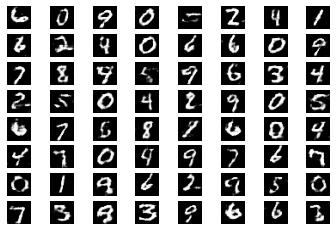

 13%|█▎        | 2/15 [00:22<02:30, 11.57s/it]

step： 2000, d_loss: 1.3781, g_loss: 0.7070, q_loss: 0.2594


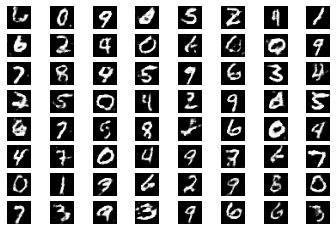

 20%|██        | 3/15 [00:33<02:15, 11.28s/it]

step： 3000, d_loss: 1.3851, g_loss: 0.7049, q_loss: 0.3927


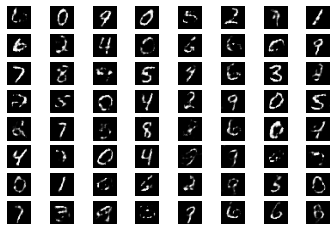

 27%|██▋       | 4/15 [00:44<02:02, 11.16s/it]

step： 4000, d_loss: 1.3824, g_loss: 0.6975, q_loss: 0.3555


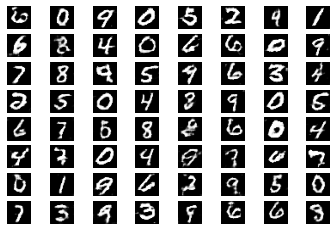

 33%|███▎      | 5/15 [00:54<01:50, 11.06s/it]

step： 5000, d_loss: 1.3840, g_loss: 0.6948, q_loss: 0.4447


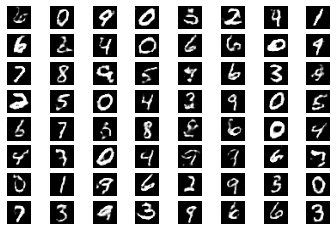

 40%|████      | 6/15 [01:05<01:38, 10.96s/it]

step： 6000, d_loss: 1.3851, g_loss: 0.6945, q_loss: 0.3410


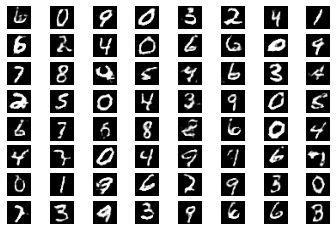

 47%|████▋     | 7/15 [01:16<01:26, 10.87s/it]

step： 7000, d_loss: 1.3862, g_loss: 0.6938, q_loss: 0.4889


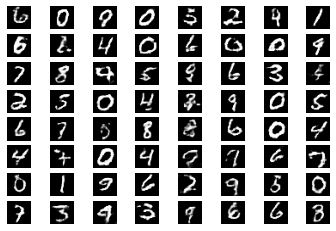

 53%|█████▎    | 8/15 [01:26<01:14, 10.71s/it]

step： 8000, d_loss: 1.3862, g_loss: 0.6936, q_loss: 0.4633


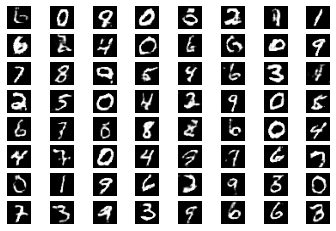

 60%|██████    | 9/15 [01:37<01:04, 10.73s/it]

step： 9000, d_loss: 1.3862, g_loss: 0.6935, q_loss: 0.4086


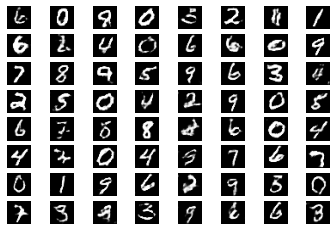

 67%|██████▋   | 10/15 [01:48<00:53, 10.71s/it]

step： 10000, d_loss: 1.3862, g_loss: 0.6933, q_loss: 0.5700


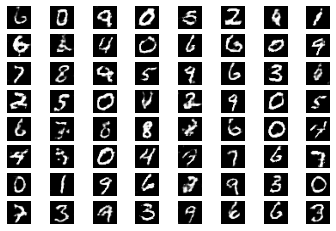

 73%|███████▎  | 11/15 [01:58<00:42, 10.70s/it]

step： 11000, d_loss: 1.3855, g_loss: 0.6945, q_loss: 0.6816


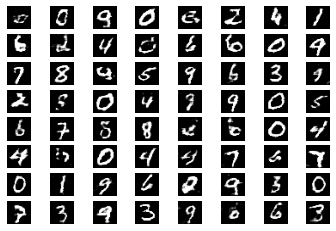

 80%|████████  | 12/15 [02:09<00:32, 10.69s/it]

step： 12000, d_loss: 1.3810, g_loss: 0.6987, q_loss: 0.6427


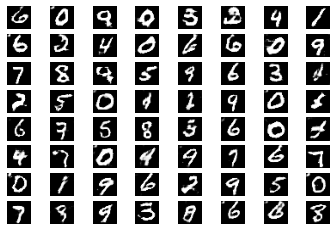

 87%|████████▋ | 13/15 [02:20<00:21, 10.72s/it]

step： 13000, d_loss: 1.3809, g_loss: 0.7025, q_loss: 0.5761


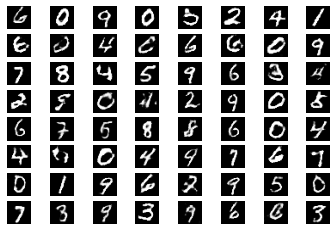

 93%|█████████▎| 14/15 [02:31<00:10, 10.77s/it]

step： 14000, d_loss: 1.3788, g_loss: 0.7011, q_loss: 0.5230


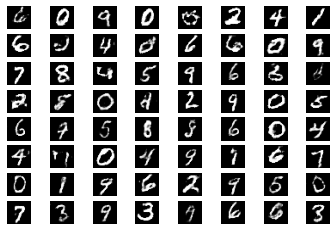

100%|██████████| 15/15 [02:41<00:00, 10.79s/it]


In [10]:
train_res_mnist, model_mnist = main(args)
train_res_mnist = np.array(train_res_mnist)

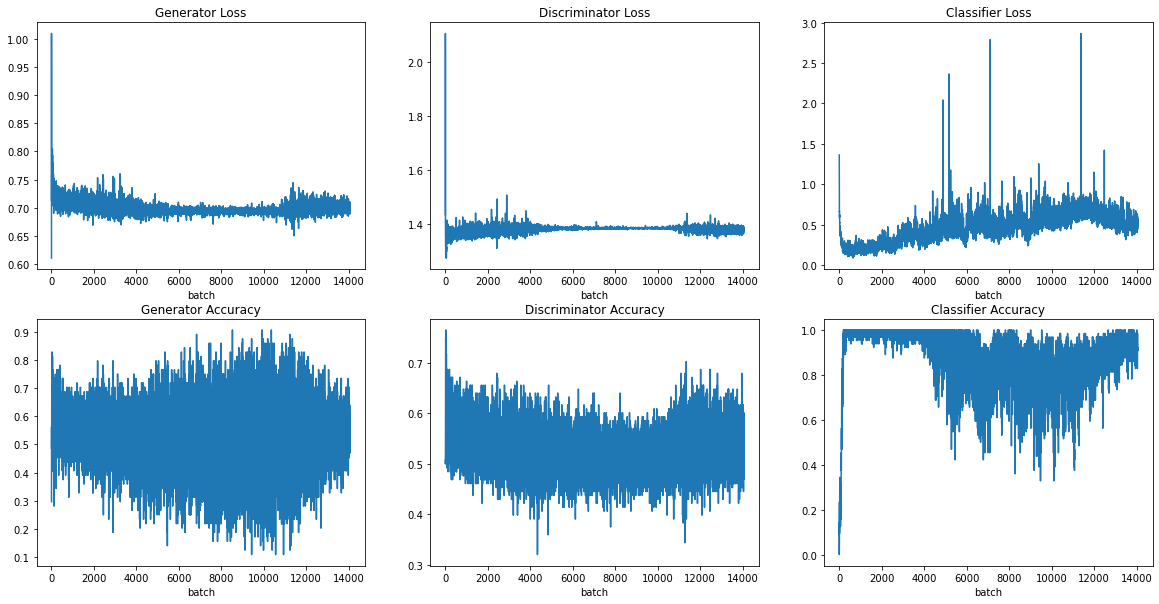

In [11]:
titles = ['Generator Loss','Discriminator Loss', 
          'Classifier Loss', 'Generator Accuracy', 
          'Discriminator Accuracy', 'Classifier Accuracy']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.reshape(-1)
for i in range(len(titles)):
    axes[i].plot(train_res_mnist[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('batch')

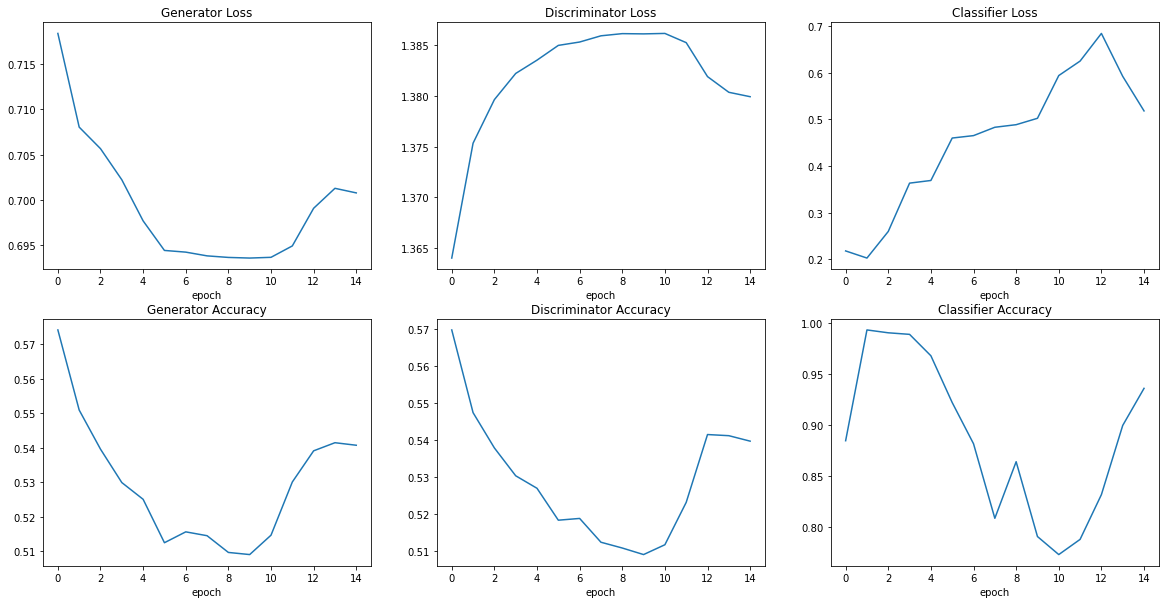

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.reshape(-1)
n_train = 60000
for i in range(len(titles)):
    train_log_epoch = batch_to_epoch(train_res_mnist[i], n_train // args['batch_size'])
    axes[i].plot(range(len(train_log_epoch)), train_log_epoch, '-')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('epoch')

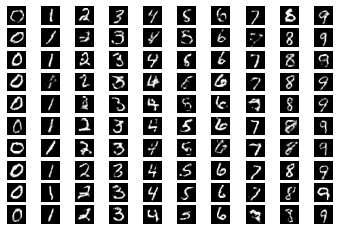

In [13]:
# Get the trained generator
trained_generator_mnist = model_mnist.g
size = (10, 10)
# generate noise (latent_points) and labels
latent_points, _ = generate_latent_points(
    model_mnist.z_dim, size[0] * size[1], 'uniform')
labels = asarray([x for _ in range(10) for x in range(10)])
labels = tf.one_hot(labels, 10).numpy()

continuous_code = tf.random.uniform(
                    shape=[size[0] * size[1],
                           model_mnist.len_continuous_code],
                    minval=-1.0, maxval=1.0, dtype=tf.dtypes.float32)
test_codes = tf.concat(
    [labels, continuous_code], 1)

# Get input to the generator
batch_z_to_disply = tf.concat([latent_points, test_codes], 1)

X = trained_generator_mnist(batch_z_to_disply, training=False)
imsave(X, size, show=True)

## Evaluation

In [14]:
# Get real disbrituion for each label.
# Image data: values are transformed to [0, 1],
#             same as that of generator outputs.
# Dictionary stats_real, example: stats[0] = [mean_0, cov_0]
stats_real = get_mean_cov_for_each_label(datasets='mnist')


# Calculate FID for each label.
# 1. For each label i,
#    use 1000 fake images to calculate the generated distribution.
# 2. Then calculate fid for each label using fake & real distribution.
nClass = 10
fake_num = 6400
stats_fake = {}

trained_generator_mnist = model_mnist.g # mnist generator

# generate noise (latent_points)
latent_points, _ = generate_latent_points(
    model_mnist.z_dim, fake_num, 'uniform')

continuous_code = tf.random.uniform(
                    shape=[fake_num,
                           model_mnist.len_continuous_code],
                    minval=-1.0, maxval=1.0, dtype=tf.dtypes.float32)

for i in range(nClass):
    labels = np.full(shape=(fake_num,), fill_value=i, dtype=np.int32)
    labels = tf.one_hot(labels, 10).numpy()
    test_codes = tf.concat([labels, continuous_code], 1)
    
    # Get input to the generator
    batch_z_to_disply = tf.concat([latent_points, test_codes], 1)
    
    X = trained_generator_mnist(batch_z_to_disply, training=False)
    fake_values = X.numpy().reshape(X.shape[0], -1)
    # generated values should be in [0, 1], because used sigmoid activation
    assert np.min(fake_values) >= -0.01 and np.max(fake_values) <= 1.01
    mean = fake_values.mean(axis=0)
    cov = np.cov(fake_values.T) # 784 x 784
    stats_fake[i] = [mean, cov]
    
fid_list = [] # smaller == better
for i in range(nClass):
    m, c = stats_real[i]
    m_fake, c_fake = stats_fake[i]
    fid_list.append(frechet_distance(m, c, m_fake, c_fake))

dataset mnist


/home/featurize/data/deep_learning_project/cgan/GANs-collections-tf2.0_keras-eager_mode/evaluation.py:59: Warning: Rank deficient covariance matrix, Frechet distance will not be accurate.
  'Frechet distance will not be accurate.', Warning)


In [15]:
# fid_list = [1,1,2,1.0,2,1,0.1,0.01,1,0]
mnist_result = pd.DataFrame()
mnist_result['label'] = [str(i) for i in range(nClass)] + ['average']
mnist_result['Frechet Inception Distance - MNIST'] = list(fid_list) + [np.mean(fid_list)]
mnist_result.set_index('label')

,Frechet Inception Distance - MNIST
label,
0,9.369388
1,3.851954
2,10.622404
3,8.162546
4,10.152145
5,8.646389
6,7.406569
7,7.057516
8,9.633246


# Fashion Mnist

## Train

In [16]:
# Set parameters
args = get_args()
args['datasets'] = 'fashion_mnist'
# Set epoch to a small number just to test the code
args['epoch'] = 15

geneartor
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
dense_layer_6 (DenseLayer)   (None, 1024)              76800     
_________________________________________________________________
batch_norm_6 (BatchNorm)     (None, 1024)              4096      
_________________________________________________________________
re_lu_78 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_layer_7 (DenseLayer)   (None, 6272)              6428800   
_________________________________________________________________
batch_norm_7 (BatchNorm)     (None, 6272)              25088     
_________________________________________________________________
re_lu_79 (ReLU)              (None, 6272)        

  7%|▋         | 1/15 [00:10<02:31, 10.79s/it]

step： 1000, d_loss: 1.3649, g_loss: 0.7174, q_loss: 0.1836


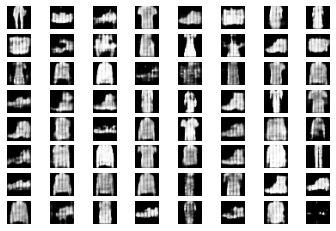

 13%|█▎        | 2/15 [00:21<02:20, 10.79s/it]

step： 2000, d_loss: 1.3576, g_loss: 0.7243, q_loss: 0.2286


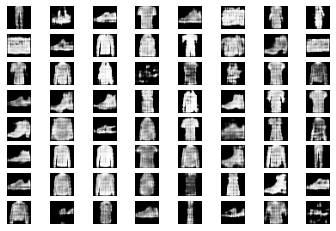

 20%|██        | 3/15 [00:32<02:09, 10.78s/it]

step： 3000, d_loss: 1.3475, g_loss: 0.7282, q_loss: 0.2791


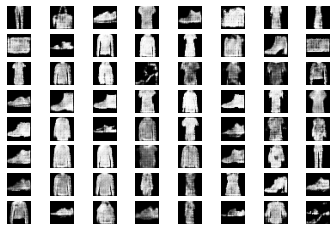

 27%|██▋       | 4/15 [00:42<01:58, 10.73s/it]

step： 4000, d_loss: 1.3439, g_loss: 0.7419, q_loss: 0.3315


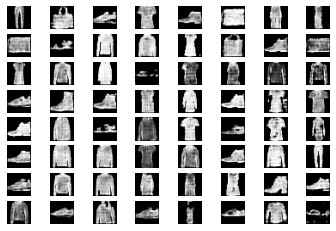

 33%|███▎      | 5/15 [00:53<01:47, 10.73s/it]

step： 5000, d_loss: 1.3304, g_loss: 0.7551, q_loss: 0.3177


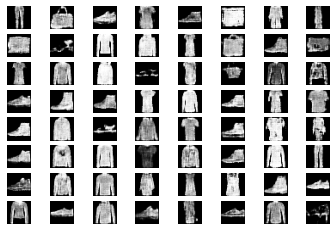

 40%|████      | 6/15 [01:04<01:36, 10.68s/it]

step： 6000, d_loss: 1.3248, g_loss: 0.7667, q_loss: 0.4438


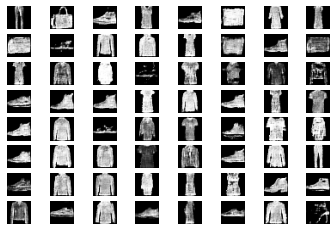

 47%|████▋     | 7/15 [01:15<01:25, 10.71s/it]

step： 7000, d_loss: 1.2984, g_loss: 0.7908, q_loss: 0.4515


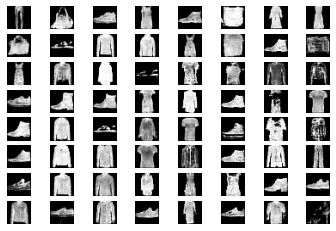

 53%|█████▎    | 8/15 [01:25<01:14, 10.62s/it]

step： 8000, d_loss: 1.3011, g_loss: 0.7996, q_loss: 0.4848


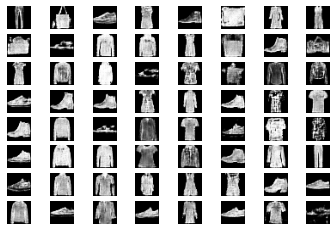

 60%|██████    | 9/15 [01:36<01:03, 10.61s/it]

step： 9000, d_loss: 1.2770, g_loss: 0.8243, q_loss: 0.4821


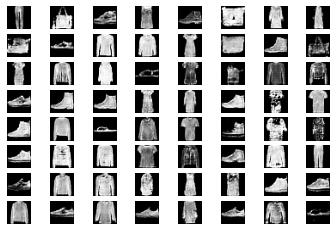

 67%|██████▋   | 10/15 [01:46<00:53, 10.64s/it]

step： 10000, d_loss: 1.2693, g_loss: 0.8406, q_loss: 0.5253


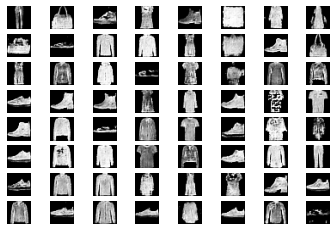

 73%|███████▎  | 11/15 [01:57<00:42, 10.70s/it]

step： 11000, d_loss: 1.2305, g_loss: 0.8662, q_loss: 0.4938


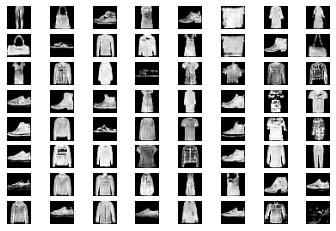

 80%|████████  | 12/15 [02:08<00:32, 10.72s/it]

step： 12000, d_loss: 1.2226, g_loss: 0.8867, q_loss: 0.4861


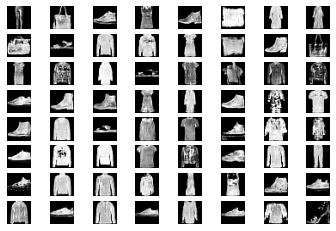

 87%|████████▋ | 13/15 [02:18<00:21, 10.68s/it]

step： 13000, d_loss: 1.2113, g_loss: 0.9055, q_loss: 0.5243


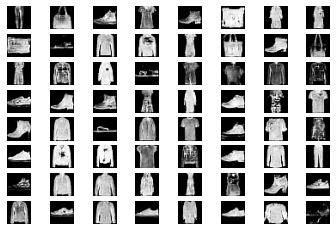

 93%|█████████▎| 14/15 [02:29<00:10, 10.70s/it]

step： 14000, d_loss: 1.2077, g_loss: 0.9157, q_loss: 0.5731


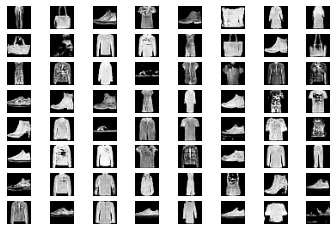

100%|██████████| 15/15 [02:40<00:00, 10.69s/it]


In [17]:
train_res_fmnist, model_fmnist = main(args)
train_res_fmnist = np.array(train_res_fmnist)

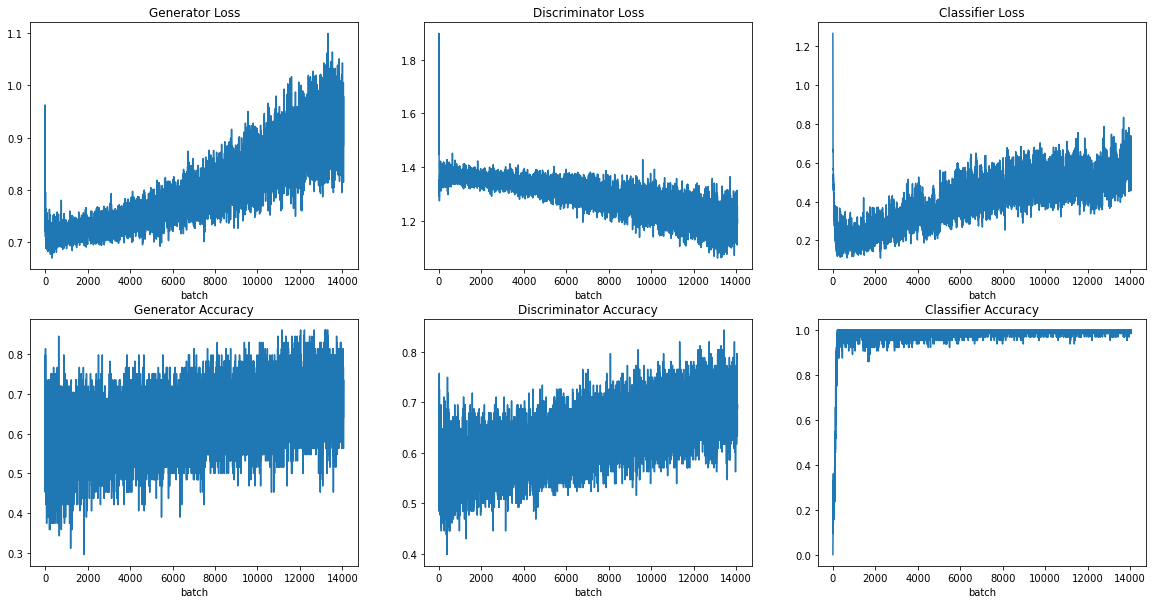

In [18]:
titles = ['Generator Loss','Discriminator Loss', 
          'Classifier Loss', 'Generator Accuracy', 
          'Discriminator Accuracy', 'Classifier Accuracy']
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.reshape(-1)
for i in range(len(titles)):
    axes[i].plot(train_res_fmnist[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('batch')

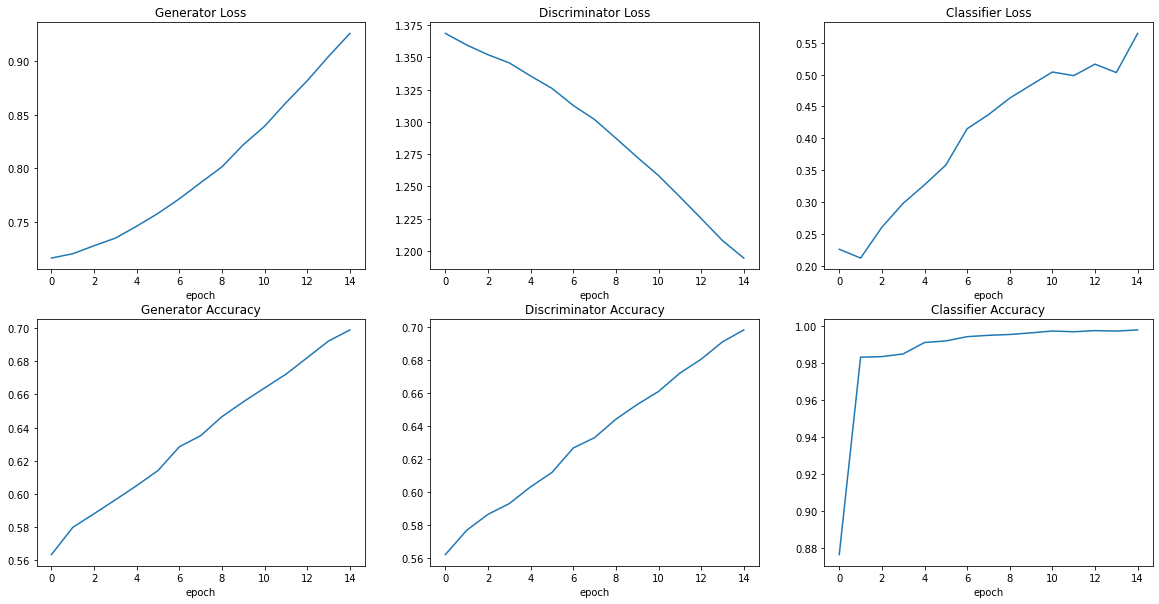

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.reshape(-1)
n_train = 60000
for i in range(len(titles)):
    train_log_epoch = batch_to_epoch(train_res_fmnist[i], n_train // args['batch_size'])
    axes[i].plot(range(len(train_log_epoch)), train_log_epoch, '-')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('epoch')

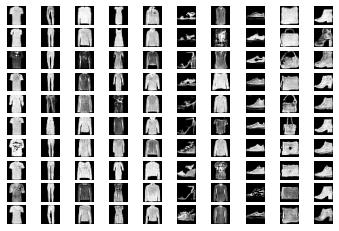

In [20]:
# Get the trained generator
trained_generator_fmnist = model_fmnist.g

size = (10, 10)
# generate noise (latent_points) and labels
latent_points, _ = generate_latent_points(
    model_mnist.z_dim, size[0] * size[1], 'uniform')
labels = asarray([x for _ in range(10) for x in range(10)])
labels = tf.one_hot(labels, 10).numpy()

continuous_code = tf.random.uniform(
                    shape=[size[0] * size[1],
                           model_mnist.len_continuous_code],
                    minval=-1.0, maxval=1.0, dtype=tf.dtypes.float32)
test_codes = tf.concat(
    [labels, continuous_code], 1)

# Get input to the generator
batch_z_to_disply = tf.concat([latent_points, test_codes], 1)

X = trained_generator_fmnist(batch_z_to_disply, training=False)
# plot the result
imsave(X, size, show=True)

## Evaluation

In [21]:
# Get real disbrituion for each label.
# Image data: values are transformed to [0, 1],
#             same as that of generator outputs.
# Dictionary stats_real, example: stats[0] = [mean_0, cov_0]
stats_real = get_mean_cov_for_each_label(datasets='fashion_mnist')


# Calculate FID for each label.
# 1. For each label i,
#    use 1000 fake images to calculate the generated distribution.
# 2. Then calculate fid for each label using fake & real distribution.
nClass = 10
fake_num = 6400
stats_fake = {}

trained_generator_fmnist = model_fmnist.g # mnist generator

# generate noise (latent_points)
latent_points, _ = generate_latent_points(
    model_fmnist.z_dim, fake_num, 'uniform')

continuous_code = tf.random.uniform(
                    shape=[fake_num,
                           model_fmnist.len_continuous_code],
                    minval=-1.0, maxval=1.0, dtype=tf.dtypes.float32)

for i in range(nClass):
    labels = np.full(shape=(fake_num,), fill_value=i, dtype=np.int32)
    labels = tf.one_hot(labels, 10).numpy()
    test_codes = tf.concat([labels, continuous_code], 1)
    
    # Get input to the generator
    batch_z_to_disply = tf.concat([latent_points, test_codes], 1)
    
    X = trained_generator_fmnist(batch_z_to_disply, training=False)
    fake_values = X.numpy().reshape(X.shape[0], -1)
    # generated values should be in [0, 1], because used sigmoid activation
    assert np.min(fake_values) >= -0.01 and np.max(fake_values) <= 1.01
    mean = fake_values.mean(axis=0)
    cov = np.cov(fake_values.T) # 784 x 784
    stats_fake[i] = [mean, cov]
    
fid_list = [] # smaller == better
for i in range(nClass):
    m, c = stats_real[i]
    m_fake, c_fake = stats_fake[i]
    fid_list.append(frechet_distance(m, c, m_fake, c_fake))

dataset fashion_mnist


/home/featurize/data/deep_learning_project/cgan/GANs-collections-tf2.0_keras-eager_mode/evaluation.py:59: Warning: Rank deficient covariance matrix, Frechet distance will not be accurate.
  'Frechet distance will not be accurate.', Warning)


In [22]:
fmnist_result = pd.DataFrame()
fmnist_result['label'] = [str(i) for i in range(nClass)] + ['average']
fmnist_result['Frechet Inception Distance - Fashion-MNIST'] = list(fid_list) + [np.mean(fid_list)]
fmnist_result.set_index('label')

,Frechet Inception Distance - Fashion-MNIST
label,
0,5.390815
1,2.367475
2,4.346625
3,4.090466
4,3.941421
5,7.751769
6,4.291378
7,4.000425
8,7.966800
